# Assignment 3

# Lucas Schmidt Ferreira de Araujo

## Implementation of the paper 

* Cheuk, Terry HF, and Ton CF Vorst. "Currency lookback options and observation frequency: a binomial approach." Journal of International Money and Finance 16.2 (1997): 173-187.

In [1]:
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set_style("whitegrid")
sns.set_palette("rocket")
warnings.filterwarnings("ignore")

## Pricing of lookback options with floating strike

In [2]:
def lookback_float_BS_price(S_0, T, r, sigma, call = True):
    """
    Prices a floating strike lookback option using the Black-Scholes formula.
    """
    M = S_0
    d1 = (np.log(S_0 / M) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if call:
        price = S_0 * norm.cdf(d1) - M * np.exp(-r * T) * norm.cdf(d2) + \
                S_0 * np.exp(-r*T) * sigma**2 / (2*r) * ((S_0/M) ** (-2*r / sigma**2) * norm.cdf(-d1 + 2*r*np.sqrt(T)/sigma) - np.exp(r*T) * norm.cdf(-d1))
    else:
        price = M * np.exp(-r * T) * norm.cdf(-d2) - S_0 * norm.cdf(-d1) + \
                S_0 * np.exp(-r*T) * sigma**2 / (2*r) * (-(S_0/M) ** (-2*r / sigma**2) * norm.cdf(d1 - 2*r*np.sqrt(T)/sigma) + np.exp(r*T) * norm.cdf(d1))
    
    return price

In [3]:
def lookback_float_binomial_tree_price(S_0, T, r, sigma, n, call = True):
    """
    Prices a floating strike lookback option using standard binomial trees.
    """
    dt = T / n   
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    S = np.array([[int(bit) for bit in f"{i:0{n}b}"] for i in range(2**n)])
    S = np.hstack((S_0 * np.ones(S.shape[0]).reshape(-1, 1), S)) 
    for i in range(S.shape[0]):
        for j in range(1, S.shape[1]):
            if S[i, j] == 1.:
                S[i, j] = S[i, j - 1] * u
            else:
                S[i, j] = S[i, j - 1] * d

    if call:
        payoffs = S[:, -1] - S.min(axis=1)
    else:
        payoffs = S.max(axis=1) - S[:, -1]

    for step in range(n, 0, -1):
        payoffs = np.array([
            np.exp(-r * dt) * ((1-p) * payoffs[2*i] + p * payoffs[2*i + 1])
            for i in range(2**(step-1))
        ])
    return payoffs[0]
    

In [40]:
def lookback_float_binomial_tree_price_CV(S0, T, sigma, r_d, r_f, N, call=True):
    """
    Prices a floating strike lookback option using a binomial tree using Cheuk-Vrost Method.
    
    Parameters:
        S0 (float): Initial price of the underlying asset.
        T (float): Time to maturity.
        N (int): Number of time steps.
        sigma (float): Volatility of the underlying asset.
        r_d (float): Domestic risk-free rate.
        r_f (float): Foreign risk-free rate.
        option_type (str): 'call' for a call option or 'put' for a put option.

    Returns:
        float: The price of the lookback option.
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    r = np.exp(r_d * dt)
    mu = np.exp((r_d - r_f) * dt)
    q = (mu * u - 1) / (mu * (u - d))
    V = np.zeros((N + 1, N + 1))

    # Terminal condition
    if call:
        for k in range(N + 1):
            V[k, N] = 1 - u**(-k) 
    else:
        for k in range(N + 1):
            V[k, N] = u**k - 1

    # Backward induction
    for j in range(N - 1, -1, -1):
        for k in range(j + 1):
            if k == 0:
                V[k, j] = mu * (q * V[k + 1, j + 1] + (1 - q) * V[k, j + 1]) / r
            else:
                V[k, j] = mu * (q * V[k + 1, j + 1] + (1 - q) * V[k - 1, j + 1]) / r
    return S0 * V[0, 0]

### Validation with the Paper


In [6]:
S_0 = 100
rd = .04
rf = .07
T = .5

sigma1 = 0.1
sigma2 = 0.2
sigma3 = 0.3

N_values = [50, 100, 500, 1000]
val1 = {}
val2 = {}
val3 = {}

# Iterate through the different values of N
for N in N_values:
    val1[N] = lookback_float_binomial_tree_price_CV(S_0, T , sigma1, rd, rf , N)
    val2[N] = lookback_float_binomial_tree_price_CV(S_0, T , sigma2, rd, rf , N)
    val3[N] = lookback_float_binomial_tree_price_CV(S_0, T , sigma3, rd, rf , N)

# Print the results for each N value
for N in N_values:
    print(f"For N = {N}:")
    print(f"  Sigma1 = {val1[N]}")
    print(f"  Sigma2 = {val2[N]}")
    print(f"  Sigma3 = {val3[N]}")


For N = 50:
  Sigma1 = 4.244877247535358
  Sigma2 = 8.969303270635
  Sigma3 = 13.521711234759145
For N = 100:
  Sigma1 = 4.367264399411915
  Sigma2 = 9.20071863812764
  Sigma3 = 13.850120874857852
For N = 500:
  Sigma1 = 4.537052850268733
  Sigma2 = 9.52164925649823
  Sigma3 = 14.305107722358246
For N = 1000:
  Sigma1 = 4.578378346822036
  Sigma2 = 9.599737086167785
  Sigma3 = 14.41573069404063


In [7]:
S_0 = 100
T = 0.5
r = 0.05
sigma = 0.02

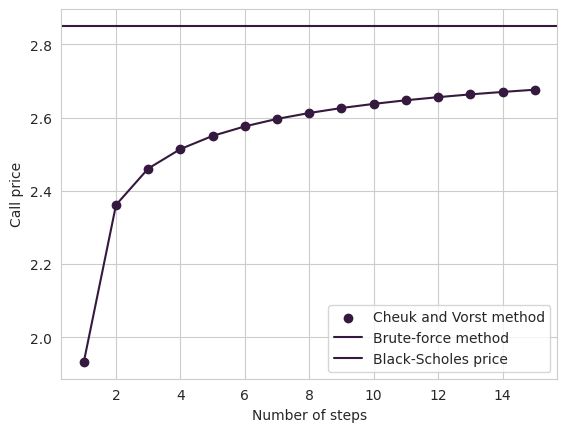

In [8]:
N = np.arange(1,16)
cv = np.array([lookback_float_binomial_tree_price_CV(S_0, T, sigma , r, 0 , n) for n in N])
brute = np.array( [lookback_float_binomial_tree_price(S_0, T, r, sigma, n) for n in N] )

plt.scatter(N, cv, label = "Cheuk and Vorst method")
plt.plot(N, brute, label = "Brute-force method")
plt.axhline(y = lookback_float_BS_price(S_0, T, r, sigma), label = "Black-Scholes price")
plt.xlabel("Number of steps")
plt.ylabel("Call price")
plt.legend()

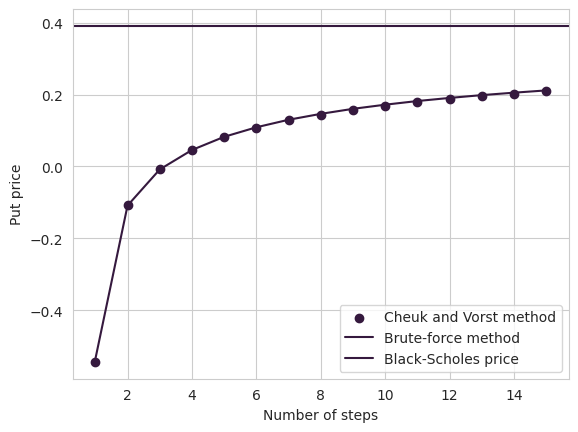

In [42]:
N = np.arange(1,16)
cv = np.array([lookback_float_binomial_tree_price_CV(S_0, T, sigma , 0, r , n , call = False) for n in N])
brute = np.array( [lookback_float_binomial_tree_price(S_0, T, r, sigma, n , call=False) for n in N] )

plt.scatter(N, cv, label = "Cheuk and Vorst method")
plt.plot(N, brute, label = "Brute-force method")
plt.axhline(y = lookback_float_BS_price(S_0, T, r, sigma , call = False), label = "Black-Scholes price")
plt.xlabel("Number of steps")
plt.ylabel("Put price")
plt.legend()